# CS330: Unsupervised Feature-Learning via Meta-learning
Test on CelebA dataset with labeled data. This can serve as a base line.
dataGenerator here can be used with StyleGAN trained protonet for testing. 

In [ ]:
# Load weight into StyleGAN model

!git clone https://github.com/dnmarch/stylegan.git
!gdown --id 1GLDZpU3N_fb-5kgVG-dTmNq0PxlE-iM3
!gdown --id 1TKbv_bR6KZOPr_ms2yuz5s9Fk2HEl2MR
from stylegan.DataGenerator import *
from stylegan.stylegan import *
from stylegan.ProtoNet import *
model = StyleGAN_G()
model.built = True
model.load_weights('./stylegan_c.h5')
weights = dict()
for layer in model.layers:
    print(layer.name)
    weights[layer.name] = layer.get_weights()
resolution=1024
latent_size=512
dlatent_size=512
mapping_layers=8
mapping_fmaps=512
mapping_lrmul=0.01

mapping = StyleGAN_G_mapping(latent_size, dlatent_size, mapping_layers, mapping_fmaps, mapping_lrmul)
synthesis = StyleGAN_G_synthesis(dlatent_size, resolution)
for name, weight in weights.items():
    if "mapping" in name:
        mapping.set_weights(weight)
    else:
        synthesis.set_weights(weight)

###########################################################################################################
###########################################################################################################
###########################################################################################################
###########################################################################################################
###########################################################################################################
import os
from google_drive_downloader import GoogleDriveDownloader as gdd

# Download the CelebAMask-HQ
if not os.path.isdir('./CelebAMask-HQ'):
    gdd.download_file_from_google_drive(file_id='1bOvIbpuuibn11VB7qyNjbuSsGh_VBGel',
                                        dest_path='./CelebAMask-HQ.zip',
                                        unzip=True)

!pwd
#assert os.path.isdir('./CelebAMask-HQ')

# Download img_align_celeba
if not os.path.isdir('./img_align_celeba'):
    gdd.download_file_from_google_drive(file_id='1CkLRsaegBjdQ73cM-G9gK8AjMCsHeCaH',
                                        dest_path='./img_align_celeba.zip',
                                        unzip=True)


#assert os.path.isdir('./img_align_celeba')

# Download the annotation and other files
if not os.path.isdir('./celebA_anno'):
    gdd.download_file_from_google_drive(file_id='1Q6u5E2xiuqp8ov8PhCsa8RiG1VTzhrvX',
                                        dest_path='./celebA_anno.zip',
                                        unzip=True)


#assert os.path.isdir('./Anno')


Cloning into 'stylegan'...
remote: Enumerating objects: 80, done.
remote: Counting objects: 100% (80/80), done.
remote: Compressing objects: 100% (78/78), done.
remote: Total 80 (delta 42), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (80/80), done.
Downloading...
From: https://drive.google.com/uc?id=1GLDZpU3N_fb-5kgVG-dTmNq0PxlE-iM3
To: /content/stylegan.h5
116MB [00:00, 280MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1TKbv_bR6KZOPr_ms2yuz5s9Fk2HEl2MR
To: /content/stylegan_c.h5
116MB [00:00, 173MB/s]
Instructions for updating:
Please use `layer.add_weight` method instead.
Model created.
G_mapping
G_synthesis
Unzipping...Done.
/content
Unzipping...Done.
Unzipping...Done.


# New Section

In [ ]:
!mv Anno celebA_anno

In [ ]:
!ls

celebA_anno	 CelebAMask-HQ.zip     sample_data    stylegan.h5
celebA_anno.zip  img_align_celeba      stylegan
CelebAMask-HQ	 img_align_celeba.zip  stylegan_c.h5


In [ ]:
"""Data Generator"""
import os
import numpy as np 
import pandas as pd
import random
from scipy import misc
import imageio
import cv2


######################## Directory ########################
WORK_DIR = "/content"
celebA_dir = os.path.join(WORK_DIR, 'celebA_anno')
celebA_HQ_dir = os.path.join(WORK_DIR, 'CelebAMask-HQ')
img_align_dir = os.path.join(WORK_DIR, 'img_align_celeba')
###########################################################

def read_img(img_path, resize='cut'):
    """cv2 reads BGR, Pic is RGB, reorder the the 2 axies"""
    img = imageio.imread(img_path)
    assert img is not None
    img = img_resize(img, resize)
    img = img.astype(np.float32) / 255
    img = 1 - img
    return img

def img_resize(img, how='cut'):
    """The CelebA img is (218, 178, 3), we can either resize to (256, 256) 
    or cut 0 dim to [178, 178, 3]"""
    how = how.lower()
    assert how in ['cut', 'resize']
    if how=='cut':
        img = img[20:198, :, :]
        assert img.shape == (178, 178, 3)
    if how=='resize':
        img = cv2.resize(img, (256,256))
    return img

def get_labels_df():
    id_celebA = pd.read_table(os.path.join(celebA_dir, "identity_CelebA.txt"), 
                    delim_whitespace=True, 
                    names=['file', 'idx']
                    )
    mapping = pd.read_table(os.path.join(celebA_HQ_dir, "CelebA-HQ-to-CelebA-mapping.txt"), 
                    delim_whitespace=True, 
                    names=['hq_idx','idx', 'file'], skiprows=1
                    )                

    # Get a list of HQ images that also exist in CelebA by checking the idx
    # Left join and see file is not Nan
    mapping = mapping.merge(id_celebA, how='left', on=['idx'], suffixes=('_hd', ''))
    mapping = mapping[~mapping.file.isna()]

    imgs = mapping.groupby('idx').apply(lambda x: x.shape[0]).\
            reset_index().rename(columns={0: 'counter'})

    imgs = imgs.merge(mapping, how='left', on=['idx'])
    # Find all idx with more than 10 images set to dataset ~ to omniglot
    multi_face = imgs[imgs.counter>= 10].copy()
    multi_face.sort_values('idx', inplace=True)

    assert len(multi_face.file.unique()) == len(multi_face)

    # Create Labels by re-map idx
    label_dict = {}
    for i, idx in enumerate(multi_face.idx.unique()):
        label_dict[idx] = i

    multi_face['label'] = [label_dict[k] for k in multi_face.idx.values] 
    # aligned images are in png format
    # multi_face.file = [x.replace('jpg', 'png') for x in multi_face.file]
    return multi_face

def get_images(df, hq_idx, labels, n_samples=None, shuffle=True):
    """
    Takes a set of character folders and labels and returns paths to image files
    paired with labels.    
    """
    if n_samples is not None:
        sampler = lambda x: random.sample(x, n_samples)
    else:
        sampler = lambda x: x
    images_labels = [(i, os.path.join(img_align_dir, image))
                    for i, hd_i in zip(labels, hq_idx)
                    for image in sampler(list(df[df.hq_idx==hd_i]['file'].values))
    ]
    if shuffle:
        random.shuffle(images_labels)
    return images_labels

class DataLoader(object):
  """
  Data Generator capable of generating batches of CelebA data.
  Generated image in [B, N, K, h, w, c]
  """

  def __init__(self, num_classes, num_samples_per_class, num_meta_test_classes, num_meta_test_samples_per_class, df):
    """
    Args:
      num_classes: Number of classes for classification (N-way)
      num_samples_per_class: num samples to generate per class in one batch
      num_meta_test_classes: Number of classes for classification (N-way) at meta-test time
      num_meta_test_samples_per_class: num samples to generate per class in one batch at meta-test time
      batch_size: size of meta batch size (e.g. number of functions)
    """
    self.num_samples_per_class = num_samples_per_class
    self.num_classes = num_classes
    self.num_meta_test_samples_per_class = num_meta_test_samples_per_class
    self.num_meta_test_classes = num_meta_test_classes
    self.df = get_labels_df() # main df contains [idx, counter, hq_idx, file_hd, file, label]

    WORK_DIR = "/Users/zhejianpeng/Google Drive/GaTech/AI_Cert/CS330_Multitask_MetaLearning/Final_Project"
    celebA_dir = os.path.join(WORK_DIR, 'celebA_anno')
    celebA_HQ_dir = os.path.join(WORK_DIR, 'CelebAMask-HQ')
    img_align_dir = os.path.join(WORK_DIR, 'img_align_celeba')
    
    self.img_size = (178, 178, 3) # or (256, 256, 3)

    self.resize_method = 'cut' # self.img_size 
    self.dim_output = self.num_classes

    # Construct Meta-Train, Meta-Test, Meta-Val
    face_idx = list(self.df.hq_idx.unique()) # Each hd_id map to multiple images of that face
    random.seed(123)
    np.random.seed(123)
    random.shuffle(face_idx)
    num_val = 100
    num_train = 850
    self.metatrain_face_idx = face_idx[:num_train]
    self.metaval_face_idx = face_idx[num_train: num_train+num_val]
    self.metatest_face_idx = face_idx[num_train+num_val:]   
    print(f"{num_train} Train, {num_val} Val {len(self.metatest_face_idx)} Test")

  def sample_batch(self, batch_type, batch_size, shuffle=True, swap=False):
    """
    Samples a batch for training, validation, or testing
    Args:
      batch_type: meta_train/meta_val/meta_test
      shuffle: randomly shuffle classes or not
      swap: swap number of classes (N) and number of samples per class (K) or not
    Returns:
      A a tuple of (1) Image batch and (2) Label batch where
      image batch has shape [B, N, K, h*w*c] and label batch has shape [B, N, K, N] if swap is False
      where B is batch size, K is number of samples per class, N is number of classes
    """
    if batch_type == "meta_train":
        face_idx = self.metatrain_face_idx
        num_classes = self.num_classes
        num_samples_per_class = self.num_samples_per_class
    elif batch_type == "meta_val":
        face_idx = self.metaval_face_idx
        num_classes = self.num_classes
        num_samples_per_class = self.num_samples_per_class
    else:
        face_idx = self.metatest_face_idx
        num_classes = self.num_meta_test_classes
        num_samples_per_class = self.num_meta_test_samples_per_class
    all_image_batches, all_label_batches = [], []
    for i in range(batch_size):
        sampled_character_folders = random.sample(
            face_idx, num_classes)
        labels_and_images = get_images(self.df, face_idx, range(
            num_classes), n_samples=num_samples_per_class, shuffle=False)
        labels = [li[0] for li in labels_and_images]
        images = [read_img(
            li[1], self.resize_method) for li in labels_and_images]
        images = np.stack(images)
        labels = np.array(labels).astype(np.int32)
        labels = np.reshape(
            labels, (num_classes, num_samples_per_class))
        labels = np.eye(num_classes, dtype=np.float32)[labels]
        images = np.reshape(
            images, [num_classes, num_samples_per_class, -1])

        batch = np.concatenate([labels, images], 2)
        if shuffle:
            for p in range(num_samples_per_class):
                np.random.shuffle(batch[:, p])

        labels = batch[:, :, :num_classes]
        images = batch[:, :, num_classes:]

        if swap:
            labels = np.swapaxes(labels, 0, 1)
            images = np.swapaxes(images, 0, 1)

        # Since we flattend the images previously, we want to shape it back
        # images = np.reshape(
        #     images, [num_classes, 
        #              num_samples_per_class,
        #              self.img_size[0],
        #              self.img_size[1],
        #              self.img_size[2]]
        #             )

        all_image_batches.append(images)
        all_label_batches.append(labels)
    all_image_batches = np.stack(all_image_batches)
    all_label_batches = np.stack(all_label_batches)
    return all_image_batches, all_label_batches


In [ ]:
# df = get_labels_df()
# # get_images(df, [5212, 9575, 27681, 6170, 13821], range(5), 5, False) 
# data_gen = DataGenerator(5, 6, 5, 8, df)
# batch = data_gen.sample_batch('meta_train', batch_size=1, shuffle=False)


In [ ]:
""" Utility functions. """
## NOTE: You do not need to modify this block but you will need to use it.
import numpy as np
import os
import random
import tensorflow as tf

## Loss utilities
def cross_entropy_loss(pred, label, k_shot):
  """pred, label, k_shot"""
  # return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=tf.stop_gradient(label)) / k_shot)
  return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=tf.stop_gradient(label)))


def accuracy(labels, predictions):
  """labels, predictions"""
  return tf.reduce_mean(tf.cast(tf.equal(labels, predictions), dtype=tf.float32))

850 Train, 100 Val 324 Test
4 12
Training acc: 0.6666666865348816 at epoch 0, now testing...
Average Meta-Test Accuracy: 0.54547, Meta-Test Accuracy Std: 0.13201
Training acc: 0.5333333611488342 at epoch 1, now testing...
Average Meta-Test Accuracy: 0.59033, Meta-Test Accuracy Std: 0.11365
Training acc: 0.5333333611488342 at epoch 2, now testing...
Average Meta-Test Accuracy: 0.65333, Meta-Test Accuracy Std: 0.10482
Training acc: 0.20000000298023224 at epoch 3, now testing...
Average Meta-Test Accuracy: 0.74367, Meta-Test Accuracy Std: 0.10015
Training acc: 0.5333333611488342 at epoch 4, now testing...
Average Meta-Test Accuracy: 0.64573, Meta-Test Accuracy Std: 0.10451
Training acc: 0.6000000238418579 at epoch 5, now testing...
Average Meta-Test Accuracy: 0.65860, Meta-Test Accuracy Std: 0.09987
minimum distance: 0.0213241558521986, noise level: 0.023583539575338364
Training acc: 0.5333333611488342 at epoch 6, now testing...
Average Meta-Test Accuracy: 0.67553, Meta-Test Accuracy Std:

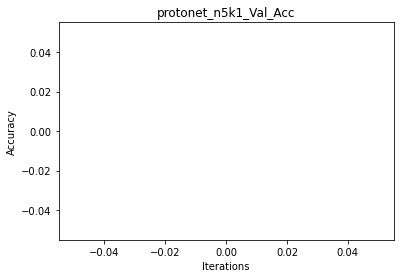

<Figure size 432x288 with 0 Axes>

In [ ]:

def run_protonet(n_way=20, k_shot=1, n_query=5, n_meta_test_way=20, k_meta_test_shot=5, n_meta_test_query=5):
    
    df = get_labels_df()
    n_epochs = 200
    n_episodes = 10

    im_width, im_height, channels = 178, 178, 3
    num_filters = 32
    latent_dim = 512
    num_conv_layers = 5
    n_meta_test_episodes = 1000

    model = ProtoNet([num_filters]*num_conv_layers, latent_dim)
    optimizer = tf.keras.optimizers.Adam()

    # call DataGenerator with k_shot+n_query samples per class
    # n_way=5, k_shot=1, n_query=5, n_meta_test_way=5, k_meta_test_shot=4, n_meta_test_query=4

    # load real data from celebA dataset
    data_loader = DataLoader(n_way, k_shot+n_query, n_meta_test_way, k_meta_test_shot+n_meta_test_query, df)
    # synthetic data
    resolution_low = 16
    resolution_high = 64
    num_std = 0.15
    noise_std = 0.001

    data_generator = DataGenerator(mapping, synthesis, K=k_shot + n_query, N=n_meta_test_way, resolution_start=resolution_low, resolution_end=resolution_high*2)

    plot_val_acc = []
    plot_test_acc = []
    plot_train_acc = []
    for ep in range(n_epochs):
        tr_acc = []
        for epi in range(n_episodes):
        #############################
        #### YOUR CODE GOES HERE ####
            images, labels = data_generator.sample_batch(1, k_shot + n_query, n_meta_test_way, num_std=num_std, noise_std=noise_std, shuffle=False, swap=False, h=im_height, w=im_width)
                #images, labels = data_generator.sample_batch("meta_train", 1, shuffle=False)
            input_tr = images[:, :, :k_shot]
            input_ts = images[:, :, k_shot:]
            label_tr = labels[:, :, :k_shot]
            label_ts = labels[:, :, k_shot:]


            support = np.reshape(input_tr, [n_way, k_shot, im_width, im_height, channels])
            query = np.reshape(input_ts, [n_way, n_query, im_width, im_height, channels])
            labels = np.reshape(label_ts, [n_way, n_query, n_way])
            #############################
            ls, ac = proto_net_train_step(model, optimizer, x=support, q=query, labels_ph=labels)
            tr_acc.append(ac)
            if (epi+1) % 10 == 0:
            #############################
            #### YOUR CODE GOES HERE ####

            # sample a batch of validation data and partition into
            # support and query sets
                i, l = data_loader.sample_batch('meta_val', batch_size=1, shuffle=False) # inputs, labels
                support, query = i[0, :, :-n_query, :], i[0, :, -n_query:, :]
                labels = l[0, :, -n_query:, :]

                # Randomly shuffle query set and labels
                query = tf.reshape(query, [n_way*n_query, -1])
                labels = tf.reshape(labels, [n_way*n_query, -1])
                indices = tf.range(start=0, limit=n_way*n_query, dtype=tf.int32)
                shuffled_indices = tf.random.shuffle(indices)
                labels = tf.gather(labels, shuffled_indices)# , axis=0)
                query = tf.gather(query, shuffled_indices)#, axis=0)
                labels = tf.reshape(labels, [n_way, n_query, n_way])

                support = tf.reshape(support, [n_way, k_shot, im_width, im_height, channels])
                query = tf.reshape(query, [n_way, n_query, im_width, im_height, channels])

                #############################
                val_ls, val_ac = proto_net_eval(model, x=support, q=query, labels_ph=labels)

            if (epi+1) % 20 == 0:
                print('[epoch {}/{}, episode {}/{}] => meta-training loss: {:.5f}, meta-training acc: {:.5f}, meta-val loss: {:.5f}, meta-val acc: {:.5f}'.format(ep+1,
                                                                          n_epochs,
                                                                          epi+1,
                                                                          n_episodes,
                                                                          ls,
                                                                          ac,
                                                                          val_ls,
                                                                          val_ac))
                plot_val_acc.append(val_ac)
        plot_train_acc.append(np.mean(tr_acc))
        print('Training acc: {} at epoch {}, now testing...'.format(tr_acc[-1], ep))
        meta_test_accuracies = []

        for epi in range(n_meta_test_episodes):
            #############################
            #### YOUR CODE GOES HERE ####

            # sample a batch of test data and partition into
            # support and query sets
            i, l = data_loader.sample_batch('test', batch_size=1, shuffle=False) # inputs, labels
            support, query = i[0, :, :-n_meta_test_query, :], i[0, :, -n_meta_test_query:, :]
            labels = l[0, :, -n_meta_test_query:, :]

            # Randomly shuffle query set and labels
            query = tf.reshape(query, [n_meta_test_way*n_meta_test_query, -1])
            labels = tf.reshape(labels, [n_meta_test_way*n_meta_test_query, -1])
            indices = tf.range(start=0, limit=n_meta_test_way*n_meta_test_query, dtype=tf.int32)
            shuffled_indices = tf.random.shuffle(indices)
            labels = tf.gather(labels, shuffled_indices)
            query = tf.gather(query, shuffled_indices)
            labels = tf.reshape(labels, [n_meta_test_way, n_meta_test_query, n_meta_test_way])

            support = tf.reshape(support, [n_meta_test_way, k_meta_test_shot, im_width, im_height, channels])
            query = tf.reshape(query, [n_meta_test_way, n_meta_test_query, im_width, im_height, channels])
            #############################
            ls, ac = proto_net_eval(model, x=support, q=query, labels_ph=labels)
            meta_test_accuracies.append(ac)
            if (epi+1) % 50 == 0:
                pass
                # print('[meta-test episode {}/{}] => loss: {:.5f}, acc: {:.5f}'.format(epi+1, n_meta_test_episodes, ls, ac))
        avg_acc = np.mean(meta_test_accuracies)
        stds = np.std(meta_test_accuracies)
        plot_test_acc.append(avg_acc)
        print('Average Meta-Test Accuracy: {:.5f}, Meta-Test Accuracy Std: {:.5f}'.format(avg_acc, stds))
    return plot_val_acc, plot_test_acc, plot_train_acc


def plot_acc(val_acc, name, save=False):
    import matplotlib.pyplot as plt
    title = f'{name}_Val_Acc'
    plt.plot(val_acc)
    plt.title(title)
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy')
    if save:
        plt.savefig(f"{title}.png")
    plt.show()
    plt.clf()

# val_acc = run_protonet('./omniglot_resized/', n_way=20, k_shot=1, n_query=5, n_meta_test_way=20,
#                         k_meta_test_shot=5, n_meta_test_query=5)
# plot_acc(val_acc, name='protonet_n20k1', save=True)


# Prob. 3
n_way = 3
val_acc, test_acc, train_acc = run_protonet(n_way=n_way, k_shot=1, n_query=5, n_meta_test_way=n_way,
                        k_meta_test_shot=6, n_meta_test_query=5)

print(test_acc)
print(train_acc)
np.save("test", test_acc)
np.save("train", train_acc)

plot_acc(val_acc, name='protonet_n5k1', save=True)



# Prob. 3
#val_acc = run_protonet(n_way=5, k_shot=1, n_query=5, n_meta_test_way=5, 
#                        k_meta_test_shot=4, n_meta_test_query=4)
              
#plot_acc(val_acc, name='protonet_n5k1', save=True)

# val_acc = run_protonet('./omniglot_resized/', n_way=30, k_shot=1, n_query=5, n_meta_test_way=30, 
#                         k_meta_test_shot=5, n_meta_test_query=5)
# plot_acc(val_acc, name='protonet_n30k1', save=True)

In [ ]:
np.save("test", test_acc)
np.save("train", train_acc)